# Boston MPO Dasymetric Population Map
To map census demographic data onto conveyal raster outputs, we need to create a gridded version of the census demographic data that will match the grid used in Conveyal analyses.

This process will follow bindary dasymetric interpolation as shown here: https://pysal.org/tobler/notebooks/binary_dasymetric.html.

A similar methodology is also used by the EPA, documented here: https://github.com/USEPA/Dasymetric-Toolbox-OpenSource

To map the census tract level demographic onto the raster grid, we will allocate population density within a tract based on two filters: residential road and land cover classification. This process starts by pulling residential road centerlines and buffering the shapes. Then, within the road buffer we find the areas that have a land classification of at least 5% of a 30 meter square area as impervious surface. Then, after applying the daymetric filters, we interpolate the area so that the population density within a tract is assigned to the grid cells that match the conveyal outputs.

In [16]:
import geopandas as gpd
import pandas as pd
#import osmnx as ox
#import contextily as ctx
import numpy as np
import matplotlib.pyplot as plt

from tobler.area_weighted import area_interpolate
from tobler.dasymetric import extract_raster_features
from tobler.util import h3fy

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)


## Prep streets from the MPO
Streets pulled from OSM, excluding primary roads.
Note, street network pulled in OSMPull notbook.

TODO: TEST IF PULLING JUST RESIDENTIAL STREETS FOR THE MPO IS more representative of where pop lives

In [2]:
# instead of pulling residential streets
# read in steets from osm pull and remove osmid in primary streets
mpo_streets = gpd.read_file("data/mpo_drive_network.gpkg",layer = 'edges')
primary_streets = gpd.read_file("data/MA_drive_primary.gpkg", layer = 'edges')
primary_ids = primary_streets.osmid.unique()
mpo_streets_res = mpo_streets[~mpo_streets.osmid.isin(primary_ids)]


project and buffer streets by 300 ft (91.44 meters)

In [27]:
# project and buffer streets by 300 ft (91.44 meters)
mpo_streets_res = mpo_streets_res.to_crs(26986)
mpo_streets_res = mpo_streets_res.buffer(91.44)
#mpo_streets_res.info()

## Prep landcover data from NLCD
2019 landcover downloaded from: full landcover (https://www.mrlc.gov/data/nlcd-2019-land-cover-conus) and impervious surfaces (https://www.mrlc.gov/data/nlcd-2019-developed-imperviousness-descriptor-conus), download: https://www.mrlc.gov/data?f%5B0%5D=year%3A2019


This step pulls in landcover with at least 5% impevious surface within the 30 meter square grid cell.

In [4]:
nlcd_path = 'data/nlcd_2019_impervious_descriptor_l48_20210604/nlcd_2019_impervious_descriptor_l48_20210604.img'

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 13938 entries, 0 to 13937
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   geometry  13938 non-null  geometry
dtypes: geometry(1)
memory usage: 109.0 KB


<AxesSubplot:>

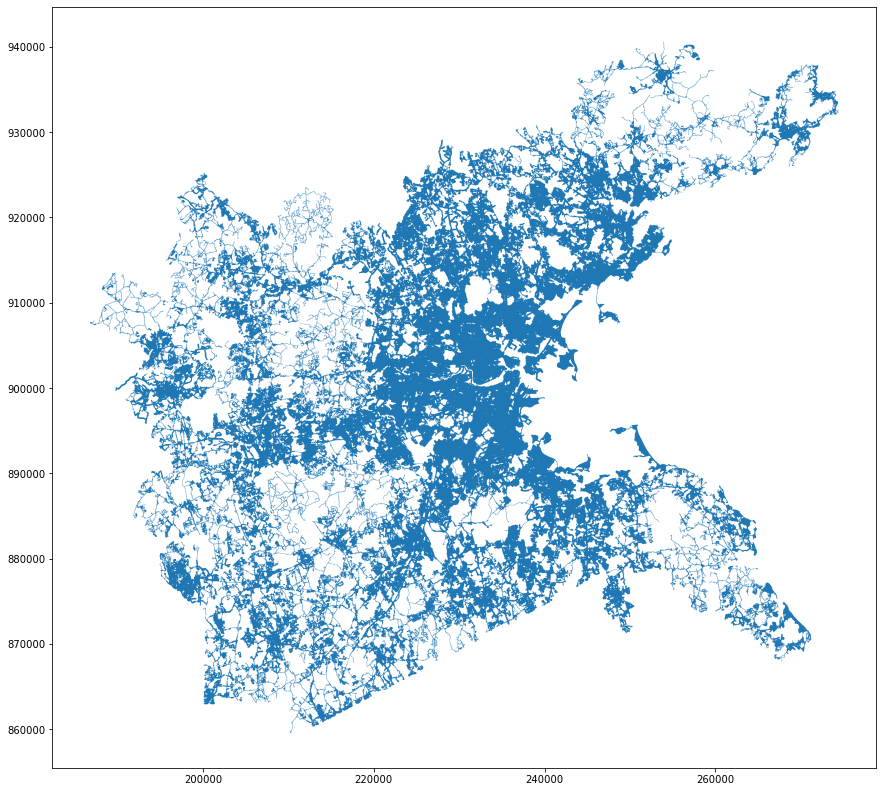

In [5]:
dev_mpo = extract_raster_features(mpo_streets_res, nlcd_path,  pixel_values=list(range(5,101)), collapse_values=True)
#dev_mpo.info()
dev_mpo = dev_mpo.to_crs(26986)

fig, ax = plt.subplots(figsize=(20,14))
dev_mpo.plot(ax=ax)

## Prep census data
tract level census data pulled with tidycensus in demographic data prep analysis scripts.

In [6]:
demo = gpd.read_file('../output/DemographicData.gpkg', layer = 'tracts_acs_dec_2020')
demo = demo.to_crs(26986)

<AxesSubplot:>

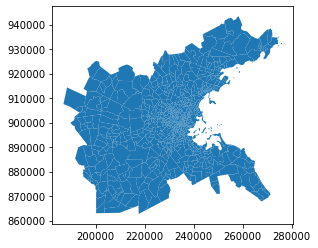

In [7]:
demo.plot()

In [28]:
mpo_grid = gpd.read_file('data/mpo_conveyal_grid_as_vector.gpkg', layer= 'workers')
mpo_grid = mpo_grid.to_crs(26986)
#mpo_grid.info()

# if we didn't need to match to conveyal grid, could use hexagons or make own grid
#mpo_hex = h3fy(demo, resolution=8)
#mpo_hex.plot()
#mpo_hex.info()

## Set up intersection between developed areas and demographic data

In [10]:
dasy = gpd.clip(demo, dev_mpo)

In [11]:
# TO DO FIND WHERE POPULATION IS DROPPING OF IN CLIP, NOTE different pop total
# COULD BE DUE TO Census population in areas in tracts that have no roads in them
print( 'pop_dec dasy' , dasy['pop_dec'].sum())

pop_dec dasy 3387383.0


From tutorial: "Clipping census geometries by the urban features leaves the census attributes intact but reshapes them. If a census tract had 2000 people in it and covered 1 sqmi, but only a quarter mile of the tract was urbanized, the new geodataframe effectively shows these 2000 people occupying the quarter mile. By passing these new data to the areal_interpolate function, we’re still assuming that population density is constant across our new geometries (a condition that may not be true in reality) but that assumption is much more plausible than when using original census geometries."

<AxesSubplot:>

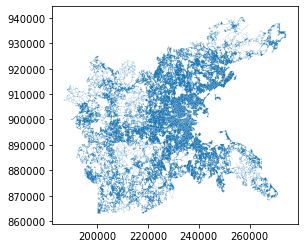

In [13]:
dasy.plot()

<AxesSubplot:>

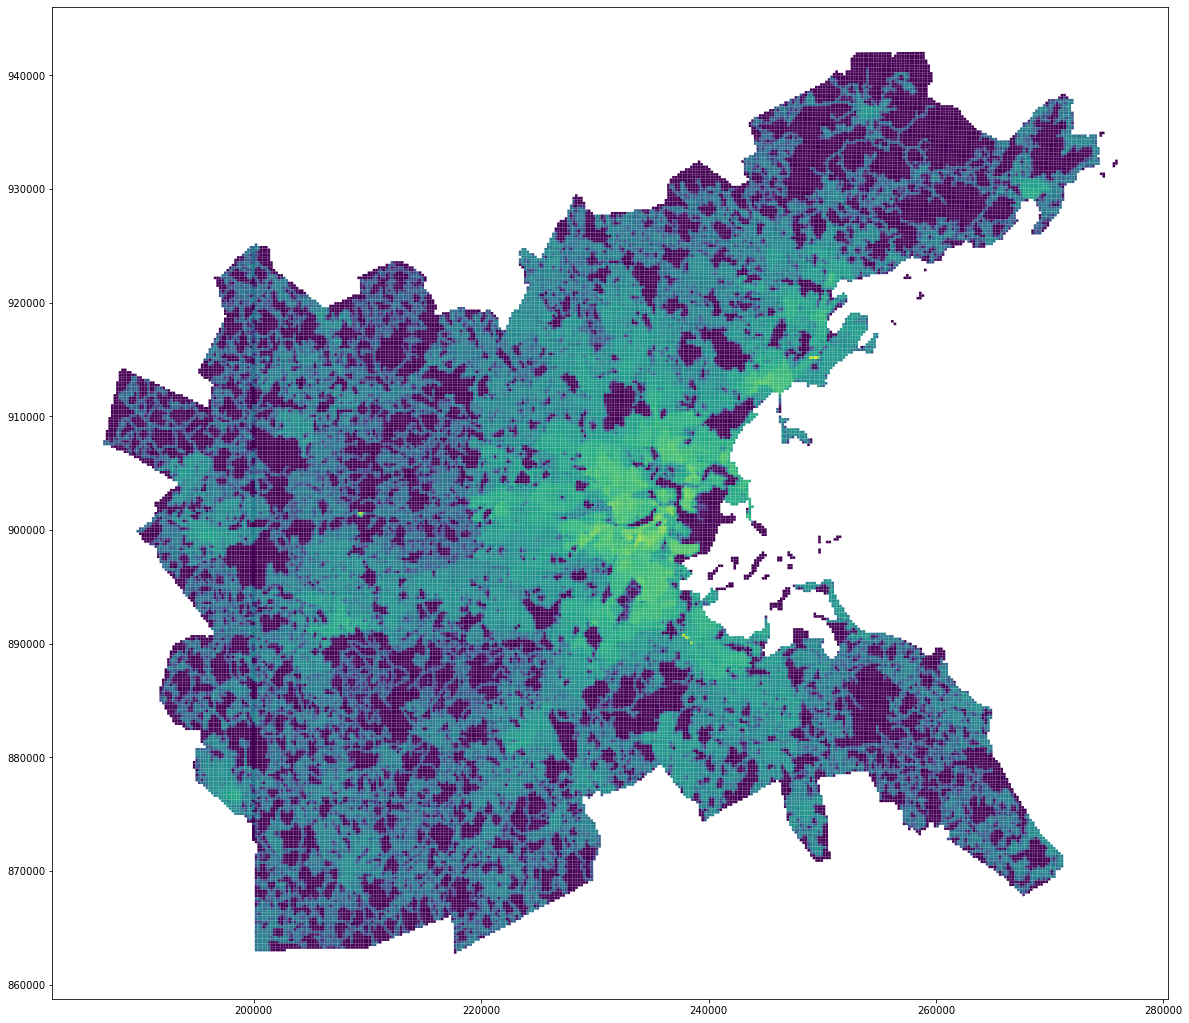

In [15]:
dasy.pop_dec = dasy.pop_dec.fillna(0)
interp = area_interpolate(dasy, mpo_grid, extensive_variables=['pop_dec'])
interp['plot'] = interp.pop_dec.apply(np.log1p)

fig, ax = plt.subplots(figsize=(20,20))
interp.to_crs(26986).plot('plot', ax=ax)

In [25]:
print( 'pop_dec interpolated' , interp['pop_dec'].sum())
print( 'pop_dec from demo ' , demo['pop_dec'].sum())

pop_dec interpolated 3387382.9742448614
pop_dec from demo  3407604.0


In [24]:
#dasy.info()
print( 'pop_dec dasy' , dasy['pop_dec'].sum())

pop_dec dasy 3387383.0


In [26]:
interp.to_file("pop_output/dasy_demo1.gpkg", layer = 'interpolated_pop_dec')
dasy.to_file("pop_output/dasy_demo1.gpkg", layer = 'dasy_clip')
dev_mpo.to_file("pop_output/dasy_demo1.gpkg", layer = 'developed_mpo')